<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

### Get data and set environment

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy.io import wavfile
import os
import soundfile as sf
import IPython
import random
import matplotlib.pyplot as plt

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import models,layers,losses,optimizers,backend,metrics
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv1D, Conv1DTranspose, MaxPool1D, Dropout,Flatten
from tensorflow.keras.models import Model


In [ ]:
# get macaques dataset from ESP, unzip, and examine
!wget https://archive.org/download/macaque_coo_calls/macaques.zip
!unzip /content/macaques.zip
!ls /content

### inspect data

In [ ]:
# create pandas dataframe with 'annotations.csv' content
df=pd.read_csv('/content/annotations.csv')
df.head(10)

,class,split,filename
0,TH,train,TH28.wav
1,TH,train,TH22.wav
2,TH,train,TH928.wav
3,TH,train,TH1145.wav
4,TH,valid,TH470.wav
5,TH,train,TH372.wav
6,TH,train,TH941.wav
7,TH,train,TH920.wav
8,TH,valid,TH791.wav
9,TH,valid,TH565.wav


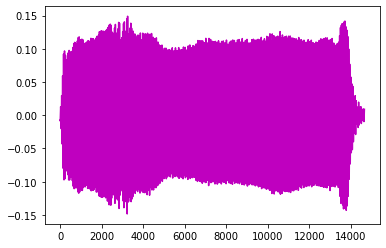

samplerate= 24414


In [ ]:
# randomly choose a filename from dataframe, then plot time-series and display audio
index=random.randrange(len(df))
filepath = os.path.join('/content',df.iloc[index].split,df.iloc[index].filename)
data, samplerate = sf.read(filepath)
plt.plot(data,'m')
plt.show()
print('samplerate=',samplerate)

IPython.display.Audio(data=data,rate=samplerate)


### read audios, zero-pad them, create spectrograms, create valid and train datasets 

In [ ]:
# let's create train and valid lists, which will contain the file location of their members

train_filenames=('/content/train/'+df.loc[df['split']=='train','filename']).values.tolist()
valid_filenames=('/content/valid/'+df.loc[df['split']=='valid','filename']).values.tolist()


In [ ]:
# give filepath, get audio
def read_audio(filepath):
  audio_binary = tf.io.read_file(filepath)
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)


In [ ]:
# zero-pad all audio signals to same length.
# max length was determined by checking all audio - after inserting them in df. 
# Skipped this part here for simplicity (np.max(df['time-series'].apply(lambda x : len(x))))
def zero_pad_t_series(signals):
  max_len=41307
  zero_ext = tf.zeros([max_len] - tf.shape(signals), dtype=tf.float32)
  signal = tf.cast(signals, tf.float32)
  signals_padded=tf.concat([signal, zero_ext], 0)
  return signals_padded

In [ ]:
# create spectrograms from audio signals after applying zero-padding first (returns abs of spectrogram, i.e. ignoring phase at the moment)
def create_spectrograms(signal):
  fft_l=512
  frame_l=512
  frame_s=128
  signal_padded=zero_pad_t_series(signal)
  signal_padded=signal_padded[:16768]# hand selected max length for faster training
  spectrogram = tf.signal.stft(signal_padded, fft_length=fft_l,frame_length=frame_l, frame_step=frame_s,pad_end=True)
  #spectrogram = tf.expand_dims(spectrogram,axis=-1) # need 3-dims for conv2D input 
  return spectrogram, signal_padded 

In [ ]:
# use tf.data to create pipelines for our datasets
def create_datasets(filepaths):
  dataset_filepaths = tf.data.Dataset.from_tensor_slices(filepaths)
  dataset = dataset_filepaths.map(read_audio, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(create_spectrograms,  num_parallel_calls=tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
train_dataset = create_datasets(train_filenames)
valid_dataset = create_datasets(valid_filenames)

### check out spectrograms

In [ ]:
for spectrogram,_  in train_dataset.take(1):
  input_shape = spectrogram.shape
print('Spectrogram dimensions:',input_shape)

Spectrogram dimensions: (131, 257)


In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

<ipython-input-12-9d8460ca3c5a>:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)
<ipython-input-12-9d8460ca3c5a>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


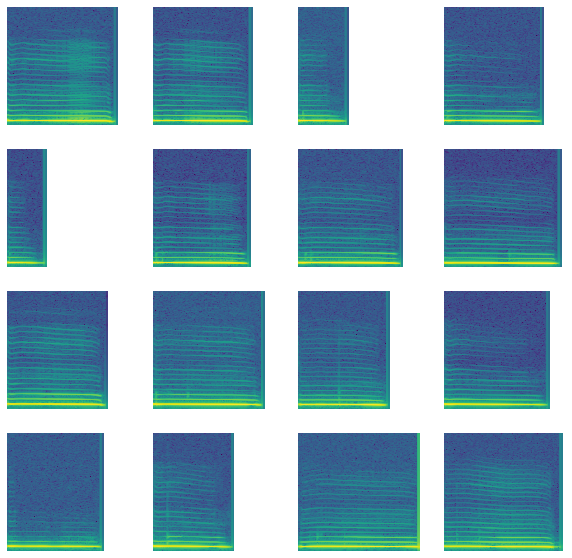

In [ ]:
rows = 4
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, audio) in enumerate(train_dataset.take(rows * cols)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(tf.abs(spectrogram).numpy()), ax)
  ax.axis('off')
  
plt.show()

### Model architecture

In [ ]:
backend.clear_session()

In [ ]:
PARAMS = {'lr': 1e-4,   
          'dropout': 0.0,
          'batch_size': 16,
          'n_epochs': 80,
          'optimizer': 'Adam',
          'loss': 'mse',
          'metrics': 'mae',
          'activations': 'relu, tanh',
          'spectrogram_input_shape' : (131,257),
          'run env' : 'google colab', 
          'data' : 'macaque coos dataset from ESP library.',  
          'save_model': 'STFT_inv_mac_conv1D_simple.h5',
          'notebook' : 'STFT_decoder_conv1D_linear.ipynb',
          'NOTES' : ''
          }

In [ ]:
train_dataset = train_dataset.batch(PARAMS['batch_size'])
valid_dataset = valid_dataset.batch(PARAMS['batch_size'])

train_dataset=train_dataset.cache().prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset=valid_dataset.cache().prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
# Simple linear network:
# -- 3 conv1D layers with BN and MaxPool each 
# -- followed by 3 up-conv1D layers with BN each
# -- and a final up-conv1D, single-filter (for single vector output) and tanh activation: [-1,1] range output

input_layer=Input(shape=PARAMS["spectrogram_input_shape"])

NNlayer=Conv1D(128, (3), activation='relu',strides=1,padding='same')(input_layer)
NNlayer=BatchNormalization()(NNlayer)      
NNlayer=MaxPool1D((2))(NNlayer)
NNlayer=Conv1D(128, (3), activation='relu',strides=1,padding='same')(NNlayer)
NNlayer=layers.BatchNormalization()(NNlayer)
NNlayer=MaxPool1D((2))(NNlayer)
NNlayer=Conv1D(256, (3), activation='relu',strides=1,padding='same')(NNlayer)
NNlayer=BatchNormalization()(NNlayer)
NNlayer=MaxPool1D((2))(NNlayer)
NNlayer=Conv1DTranspose(256, (3), activation='relu',strides=2,padding='same')(NNlayer)
NNlayer=BatchNormalization()(NNlayer)
NNlayer=Conv1DTranspose(128, (3), activation='relu',strides=2,padding='same')(NNlayer)
NNlayer=BatchNormalization()(NNlayer)
NNlayer=Conv1DTranspose(128, (3), activation='relu',strides=2,padding='same')(NNlayer)
NNlayer=BatchNormalization()(NNlayer)
output=Conv1DTranspose(1,(512),strides=128,activation='tanh')(NNlayer)
model = Model(inputs=input_layer, outputs=output)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 131, 257)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 131, 128)          98816     
_________________________________________________________________
batch_normalization (BatchNo (None, 131, 128)          512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 65, 128)           49280     
_________________________________________________________________
batch_normalization_1 (Batch (None, 65, 128)           512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 128)          

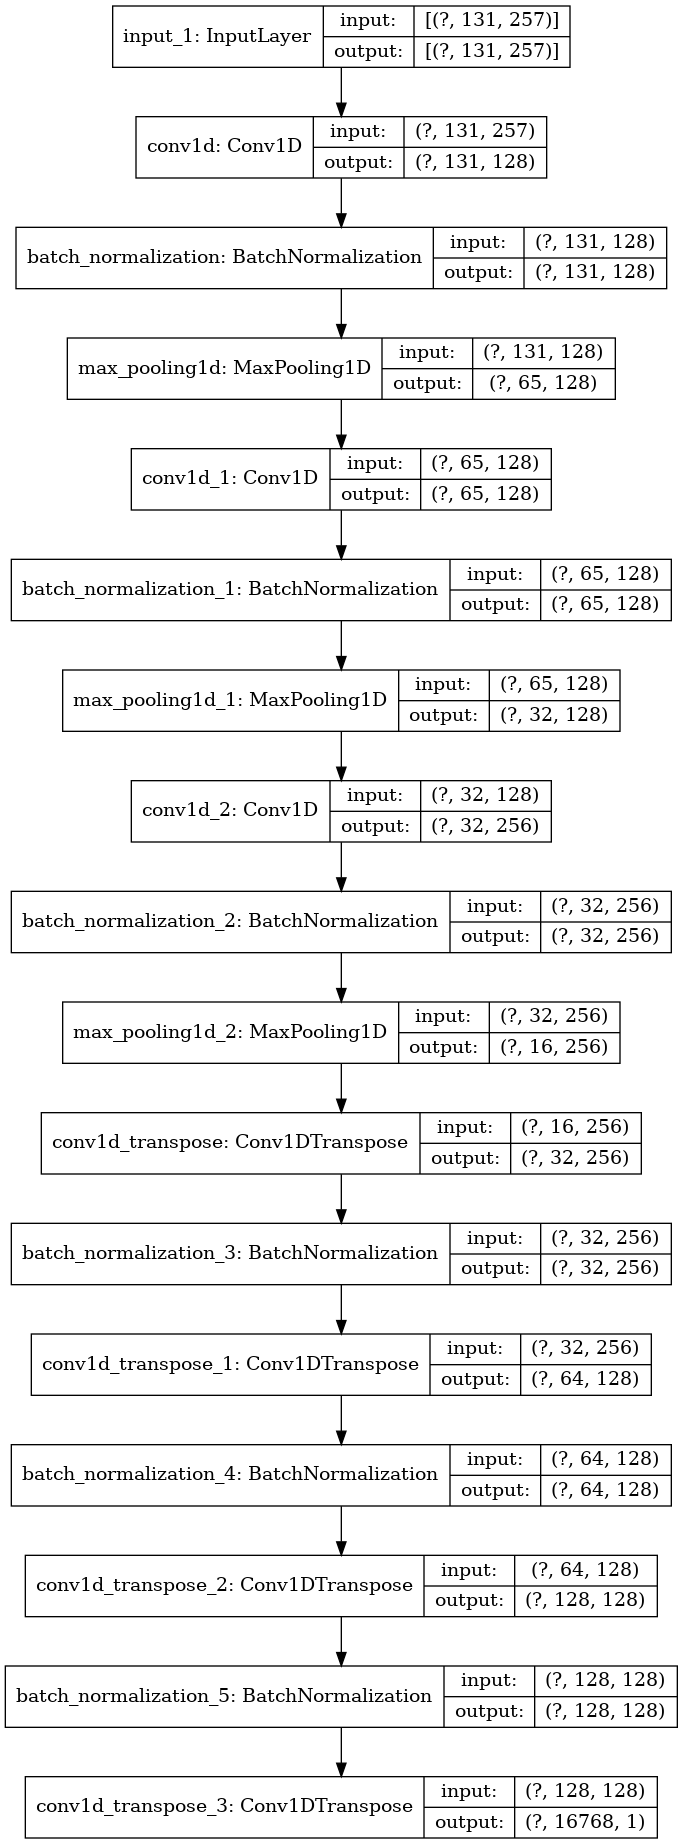

In [ ]:
# create a graph of the model layers
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True,rankdir='TB',show_layer_names=True)

### Compile and train

In [ ]:
model.compile(optimizer=optimizers.Adam(lr=PARAMS['lr']), loss=PARAMS['loss'],metrics=PARAMS['metrics'])

In [ ]:
history=model.fit(train_dataset,
                epochs=PARAMS['n_epochs'],
                shuffle=True, 
                validation_data=valid_dataset)

model.save(PARAMS['save_model'])

Epoch 1/80
365/365 [==============================] - 9s 25ms/step - loss: 0.0211 - mae: 0.0803 - root_mean_squared_error: 0.1452 - val_loss: 0.0208 - val_mae: 0.0776 - val_root_mean_squared_error: 0.1443
Epoch 2/80
365/365 [==============================] - 6s 18ms/step - loss: 0.0147 - mae: 0.0654 - root_mean_squared_error: 0.1211 - val_loss: 0.0175 - val_mae: 0.0715 - val_root_mean_squared_error: 0.1325
Epoch 3/80
365/365 [==============================] - 7s 18ms/step - loss: 0.0112 - mae: 0.0572 - root_mean_squared_error: 0.1059 - val_loss: 0.0143 - val_mae: 0.0663 - val_root_mean_squared_error: 0.1196
Epoch 4/80
365/365 [==============================] - 7s 19ms/step - loss: 0.0091 - mae: 0.0520 - root_mean_squared_error: 0.0955 - val_loss: 0.0122 - val_mae: 0.0619 - val_root_mean_squared_error: 0.1106
Epoch 5/80
365/365 [==============================] - 7s 19ms/step - loss: 0.0076 - mae: 0.0479 - root_mean_squared_error: 0.0872 - val_loss: 0.0107 - val_mae: 0.0576 - val_root_me

Epoch 41/80
365/365 [==============================] - 7s 20ms/step - loss: 0.0015 - mae: 0.0224 - root_mean_squared_error: 0.0383 - val_loss: 0.0051 - val_mae: 0.0402 - val_root_mean_squared_error: 0.0716
Epoch 42/80
365/365 [==============================] - 7s 20ms/step - loss: 0.0014 - mae: 0.0222 - root_mean_squared_error: 0.0378 - val_loss: 0.0052 - val_mae: 0.0403 - val_root_mean_squared_error: 0.0718
Epoch 43/80
365/365 [==============================] - 7s 20ms/step - loss: 0.0014 - mae: 0.0220 - root_mean_squared_error: 0.0372 - val_loss: 0.0052 - val_mae: 0.0407 - val_root_mean_squared_error: 0.0721
Epoch 44/80
365/365 [==============================] - 7s 20ms/step - loss: 0.0013 - mae: 0.0217 - root_mean_squared_error: 0.0366 - val_loss: 0.0052 - val_mae: 0.0411 - val_root_mean_squared_error: 0.0723
Epoch 45/80
365/365 [==============================] - 7s 20ms/step - loss: 0.0013 - mae: 0.0215 - root_mean_squared_error: 0.0359 - val_loss: 0.0052 - val_mae: 0.0412 - val_ro

### Plot learning curves

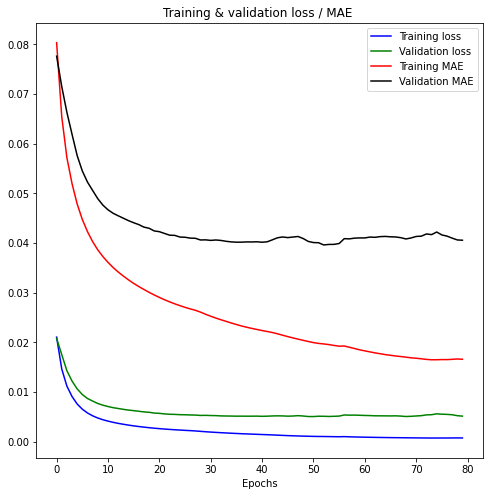

In [ ]:
epoch_num=PARAMS['n_epochs']
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']


plt.figure(figsize=(8,8))
plt.plot(range(epoch_num), loss, 'b', label='Training loss')
plt.plot(range(epoch_num), val_loss, 'g', label='Validation loss')
plt.plot(range(epoch_num), mae, 'r', label='Training MAE')
plt.plot(range(epoch_num), val_mae, 'k', label='Validation MAE')
plt.xlabel('Epochs')
plt.title('Training & validation loss / MAE ')
plt.legend()
plt.show()

### Predict on subset of validation set

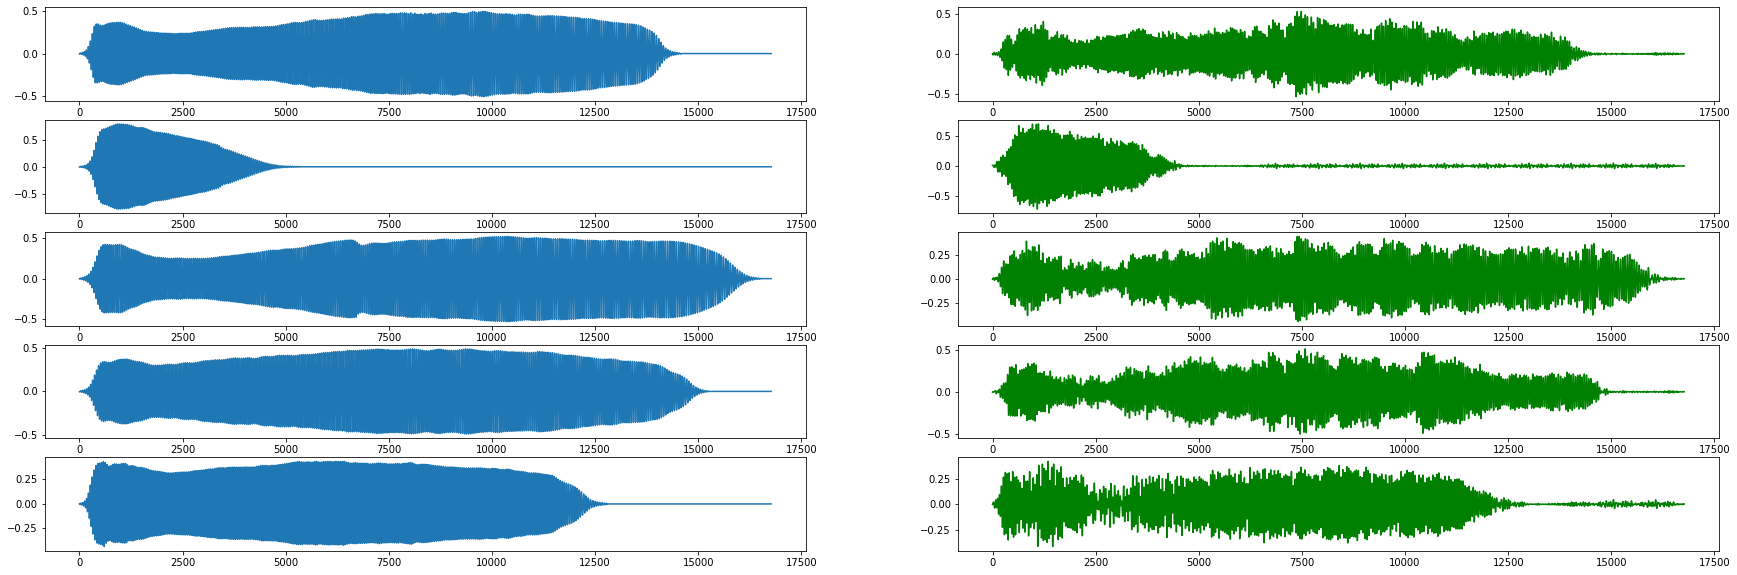

In [ ]:
# choose number of examples from validation set to predict on and compare with original t-series signals

n = 5

orig_audio=[]
decoded_audio=[]
valid_dataset = create_datasets(valid_filenames)
fig,axes=plt.subplots(n,2,figsize=(30,10))
for i, (spectrogram, audio) in enumerate(valid_dataset.shuffle(100).take(n)):
    spectrogram=tf.expand_dims(spectrogram,axis=0)
    out=model.predict(spectrogram)
    out=np.squeeze(out,axis=-1)
    out=np.squeeze(out,axis=0)
    r=i
    ax=axes[r][0]
    ax.plot(audio)
    ax=axes[r][1]
    ax.plot(out,'g')

    orig_audio.append(audio)
    decoded_audio.append(out)
    
plt.show()

In [ ]:
for i in range(n):
    display(IPython.display.Audio(orig_audio[i],rate=24414))
    print('original')
    display(IPython.display.Audio(decoded_audio[i],rate=24414))
    print('decoded')

original


decoded


original


decoded


original


decoded


original


decoded


original


decoded
